In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

### 1. Load organized conceptual geomodels

In [3]:
# Loading all conceptual geomodels contained in the int8 format file
# In this case:  code 0 is for background mud faceis, 1 for channel facies, and 2 for lobe facies

rlz_no     = 4    # The number of exported conceptual geomodel realizations
con_x_size = 400  # Cell number along x direction in the conceptual geomodels
con_y_size = 400  # Cell number along y direction in the conceptual geomodels
con_z_size = 50   # Cell number along z direction in the conceptual geomodels

concept_path = '/scratch/users/suihong/GANSimData//concpts_int8.npy'
concpts = np.load(concept_path)
concpts = concpts.transpose(1,0).reshape(rlz_no, con_x_size, con_y_size, con_z_size)
print(concpts.shape)
print(concpts.dtype)

(4, 400, 400, 50)
int8


### 2. Augment conceptual geomodels by flipping along east-west direction

In [8]:

concpts_all = np.concatenate((concpts, concpts[:,:,::-1,:]))
print(concpts_all.shape)

(8, 400, 400, 50)


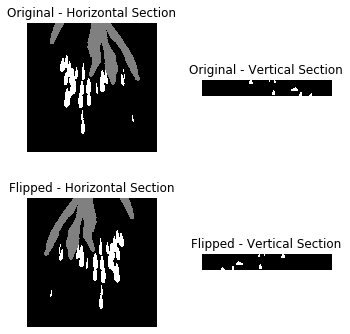

In [52]:
fig, ax = plt.subplots(2, 2)  # 2 rows, 2 columns
fig.set_size_inches(5, 5, forward=True)

# Original conceptual geomodels
ax[0, 0].imshow(concpts_all[0, :, :, 0].astype(np.float32), cmap='gray')
ax[0, 0].set_title('Original - Horizontal Section')

ax[0, 1].imshow(concpts_all[0, -1, :, :].astype(np.float32).transpose(1, 0), cmap='gray')
ax[0, 1].set_title('Original - Vertical Section')

# Flipped conceptual geomodels
ax[1, 0].imshow(concpts_all[0 + rlz_no, :, :, 0].astype(np.float32), cmap='gray')
ax[1, 0].set_title('Flipped - Horizontal Section')

ax[1, 1].imshow(concpts_all[0 + rlz_no, -1, :, :].astype(np.float32).transpose(1, 0), cmap='gray')
ax[1, 1].set_title('Flipped - Vertical Section')

# Optional: Remove axes for a cleaner look
for a in ax.flatten():
    a.axis('off')

plt.tight_layout()
plt.show()


### 3. Randomly crop conceptual geomodels into small patches

##### 3.1 Randomly crop patches from each realization

In [11]:
def rand_crop(faciesmodel, crop_num, crop_x_size, crop_y_size, crop_z_size):
    sand_indices = np.argwhere(faciesmodel > 0.9)
    crop_indices = np.random.randint(0, sand_indices.shape[0], crop_num)
    crop_pt_coos = sand_indices[crop_indices]
    [model_x_size, model_y_size, model_z_size] = faciesmodel.shape
    facies_crops = np.zeros((crop_num, crop_x, crop_y, crop_z), np.int8)        
    for k in range(crop_num):
        [pt_x, pt_y, pt_z] = crop_pt_coos[k]        
        x_e_dist = model_x_size - 1 - pt_x  # distance between sampled point to the east boundary
        y_s_dist = model_y_size - 1 - pt_y
        z_b_dist = model_z_size - 1 - pt_z        
        if x_e_dist <= crop_x_size - 1:
            dx_e = np.random.randint(0, x_e_dist + 1)
            crop_x_ed = pt_x + dx_e
            crop_x_st = crop_x_ed - crop_x_size
        else:
            crop_x_st = max(0, pt_x - np.random.randint(0, crop_x_size - 1))
            crop_x_ed = crop_x_st + crop_x_size
            
        if y_s_dist <= crop_y_size - 1:
            dy_s = np.random.randint(0, y_s_dist)
            crop_y_ed = pt_y + dy_s
            crop_y_st = crop_y_ed - crop_y_size
        else:
            crop_y_st = max(0, pt_y - np.random.randint(0, crop_y_size - 1))
            crop_y_ed = crop_y_st + crop_y_size   

        if model_z_size >= 2 * crop_z_size:            
            if pt_z <= crop_z_size:
                crop_z_st = np.random.randint(0, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size               
            elif pt_z <= model_z_size - crop_z_size:
                crop_z_st = np.random.randint(pt_z - crop_z_size, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size                 
            else:
                crop_z_ed = np.random.randint(pt_z, model_z_size)
                crop_z_st = crop_z_ed - crop_z_size
        else:
            if pt_z <= model_z_size - crop_z_size:
                crop_z_st = np.random.randint(0, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size               
            elif pt_z <= crop_z_size:
                crop_z_st = np.random.randint(0, model_z_size - crop_z_size + 1)
                crop_z_ed = crop_z_st + crop_z_size                 
            else:
                crop_z_ed = np.random.randint(pt_z, model_z_size)
                crop_z_st = crop_z_ed - crop_z_size            

        facies_crops[k] = faciesmodel[crop_x_st: crop_x_ed, crop_y_st: crop_y_ed, crop_z_st: crop_z_ed]            
    return facies_crops

In [17]:
crops_for_each_model   = 12           # Number of cropped patches in each conceptual realization
crop_x, crop_y, crop_z = 128, 128, 32 # Cell number along x, y, and z direction for each patch

facies_crops = np.zeros((rlz_no * 2, crops_for_each_model, crop_x, crop_y, crop_z), np.int8)
for i in range(rlz_no * 2):
    facies_model_i = concpts_all[i]   # shape of [400, 400, 400]
    facies_crops[i] = rand_crop(facies_model_i, crops_for_each_model, crop_x, crop_y, crop_z)    
    print(i) 

facies_crops = facies_crops.reshape(-1, 1, crop_x, crop_y, crop_z)    
print(facies_crops.shape)

0
1
2
3
4
5
6
7
(96, 1, 128, 128, 32)


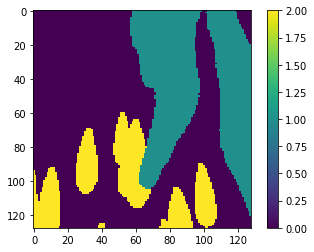

In [19]:
plt.imshow(facies_crops[3, 0, :,:,15].astype(np.float32))
plt.colorbar()

##### 3.2 Removing patches containing mostly background mud facies

In [22]:
facies_crops_num = facies_crops.shape[0]
ch_props = np.zeros((facies_crops_num, ), np.float32)
lob_props = np.zeros((facies_crops_num, ), np.float32)
ch_props = np.mean(np.where(facies_crops==1, 1, 0), axis = (1, 2, 3, 4))
lob_props = np.mean(np.where(facies_crops==2, 1, 0), axis = (1, 2, 3, 4))
mud_props = 1 - ch_props - lob_props

# Check how many crops have only channels, how many have only lobes, and how many have both
# 1 for only channels, 2 for only lobes, and 3 for both
pattern_type = np.zeros((facies_crops.shape[0]), np.int8) 
for i in range(pattern_type.shape[0]):
    if (ch_props[i] > 0.1) and (lob_props[i] > 0.1):
        pattern_type[i] = 3
    elif (ch_props[i] > 0.1) and (lob_props[i] < 0.1):
        pattern_type[i] = 1
    elif (ch_props[i] < 0.1) and (lob_props[i] > 0.1):
        pattern_type[i] = 2

(array([ 8.,  0.,  0., 20.,  0.,  0., 27.,  0.,  0., 41.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

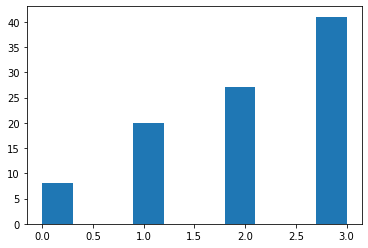

In [23]:
plt.hist(pattern_type)

In [24]:
keep_index = []
for i in range(pattern_type.shape[0]):
    if (pattern_type[i] == 1) or (pattern_type[i] == 3):
        keep_index.append(i)
    elif pattern_type[i] == 2:
        if np.random.uniform(low=0.0, high=1.0, size=None) < 0.4: keep_index.append(i)
print(len(keep_index))

76


(array([20.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0., 41.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

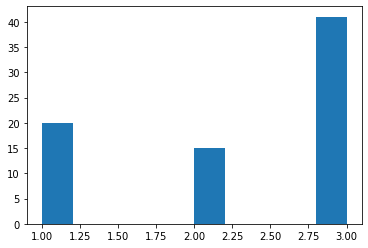

In [25]:
plt.hist(pattern_type[keep_index])

In [26]:
facies_crops = facies_crops[keep_index]
# randomly permute facies_crops:
random_seq=np.random.RandomState(232).permutation(facies_crops.shape[0])
facies_crops = facies_crops[random_seq]

print(facies_crops.shape)

(76, 1, 128, 128, 32)


### 4. Generate training well facies for each patch

In [28]:
well_points = np.zeros(facies_crops.shape, dtype = np.int8)
for i in range(facies_crops.shape[0]):
    well_points_num = np.random.choice(np.arange(1, 10), 1)  # Random choose the expected total number of well points
    xs = np.random.choice(128, well_points_num)
    ys = np.random.choice(128, well_points_num)
   # zs = np.random.choice(32, well_points_num)
    well_points[i, 0, xs, ys, :] = 1

well_facies = facies_crops * well_points + well_points
print(well_facies.shape)

(76, 1, 128, 128, 32)


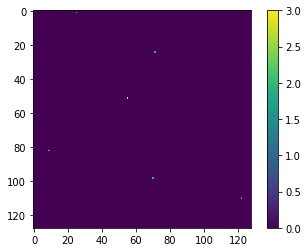

In [29]:
plt.imshow(well_facies[14, 0,:,:,25])
plt.colorbar()

(array([6453.,    0.,    0., 2939.,    0.,    0., 2512.,    0.,    0.,
           0.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

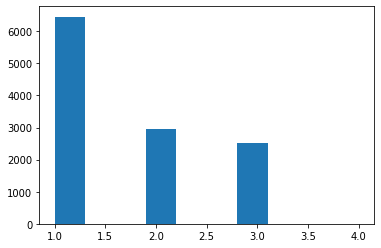

In [30]:
plt.hist(well_facies.reshape(-1), range = (1, 4))

### 5. Generate training probability cubes for each patch

##### 5.1 Create facies indicator cubes

In [32]:
facies_crops_indc_ch = np.where(facies_crops == 1, 1, 0).astype(np.int8)
facies_crops_indc_lobe = np.where(facies_crops == 2, 1, 0).astype(np.int8)


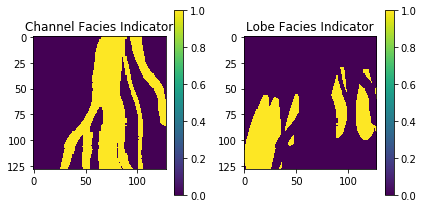

In [54]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(6, 3, forward=True)

# Channel facies indicator
im0 = ax[0].imshow(facies_crops_indc_ch[22, 0, :, :, 6])
ax[0].set_title('Channel Facies Indicator')
fig.colorbar(im0, ax=ax[0])

# Lobe facies indicator
im1 = ax[1].imshow(facies_crops_indc_lobe[22, 0, :, :, 6])
ax[1].set_title('Lobe Facies Indicator')
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()


##### 5.2 Calculate probability cubes from indicator cubes 

##### (1) Add noises to indicator cubes

In [36]:
def noise(cube, max_noise_size):
    cube_noise = np.zeros(cube.shape)
    # (1) add noise within the facies of indicator = 1 
    noise_num_max = np.round(np.sum(cube)/400)
    if noise_num_max>0:       
        ind_indices = np.argwhere(cube>=0.9)
        noise_num = np.random.randint(0, noise_num_max)
        noise_indices = np.random.randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.randint(2, max_noise_size, noise_num)  
        noise_values = np.random.uniform(-3., 1.5, noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_coo_i_z = noise_coos[i, 2]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            cube_noise[noise_coo_i_x:min(128, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(128, noise_coo_i_y + noise_size_i), noise_coo_i_z:min(32, noise_coo_i_z + noise_size_i)]=noise_value_i
   
    # (2) add noise within the facies of indicator = 0
    noise_num_max = np.round((128*128*32 - np.sum(cube))/400)
    if noise_num_max>0:
        ind_indices = np.argwhere(cube<=0.1)
        noise_num = np.random.randint(0, noise_num_max)
        noise_indices = np.random.randint(0, ind_indices.shape[0], noise_num)    
        noise_coos = ind_indices[noise_indices]
        noise_sizes = np.random.randint(2, max_noise_size, noise_num)  
        noise_values = np.random.uniform(0., 3., noise_num)
        for i in range(noise_num):
            noise_coo_i_x = noise_coos[i, 0]
            noise_coo_i_y = noise_coos[i, 1]
            noise_coo_i_z = noise_coos[i, 2]
            noise_size_i = noise_sizes[i]
            noise_value_i = noise_values[i]
            cube_noise[noise_coo_i_x:min(128, noise_coo_i_x + noise_size_i), noise_coo_i_y:min(128, noise_coo_i_y + noise_size_i), noise_coo_i_z:min(32, noise_coo_i_z + noise_size_i)]=noise_value_i
    return cube_noise

##### (2) Smooth indicator cubes to obtain probability cubes (mimicking geophysics-interpreted facies probability cubes)

In [37]:
# Using Gaussian kernels with various size to smooth indicator cubes to form the probability cubes with various blurriness. 

from scipy import ndimage

prob_rlzs = np.zeros((facies_crops.shape[0], 2, 128, 128, 32), dtype=np.float16)
for num in range(facies_crops.shape[0]):  
    if num % 100 == 0:
        print(num)  
    k = np.random.choice([3., 5., 7., 9.])
    cur_indc_ch = facies_crops_indc_ch[num, 0].astype(np.float32)
    cur_indc_lobe = facies_crops_indc_lobe[num, 0].astype(np.float32)
    cur_indc_ch_noise = noise(cur_indc_ch, min(6., k*5))
    cur_indc_lobe_noise = noise(cur_indc_lobe, min(6., k*5))    
    cur_noise_prob_ch = ndimage.gaussian_filter(cur_indc_ch_noise, sigma = (k, k, 4*k), mode = 'reflect')
    cur_noise_prob_lobe = ndimage.gaussian_filter(cur_indc_lobe_noise, sigma = (k, k, 4*k), mode = 'reflect') 
    prob_ch_without_noise = ndimage.gaussian_filter(cur_indc_ch, sigma = (k, k, 4*k), mode = 'reflect') 
    prob_lobe_without_noise = ndimage.gaussian_filter(cur_indc_lobe, (k, k, 4*k), mode = 'reflect') 
    prob_ch = prob_ch_without_noise + cur_noise_prob_ch
    prob_lobe = prob_lobe_without_noise + cur_noise_prob_lobe 

    prob_sum = prob_ch + prob_lobe  
    prob_sum_max = np.amax(prob_sum, axis = (0,1,2))
    if prob_sum_max<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.rand(1)*0.45+0.25
        prob_ch = prob_ch * prob_mx / prob_sum_max   
        prob_lobe = prob_lobe * prob_mx / prob_sum_max    
    
    if prob_sum_max>0.9: 
        prob_ch = prob_ch / prob_sum_max * 0.9
        prob_lobe = prob_lobe / prob_sum_max * 0.9
    
    prob_rlzs[num, 0] = prob_ch 
    prob_rlzs[num, 1] = prob_lobe    
    prob_rlzs[num] = np.where(prob_rlzs[num]<0.02, 0.02, prob_rlzs[num]) 

0


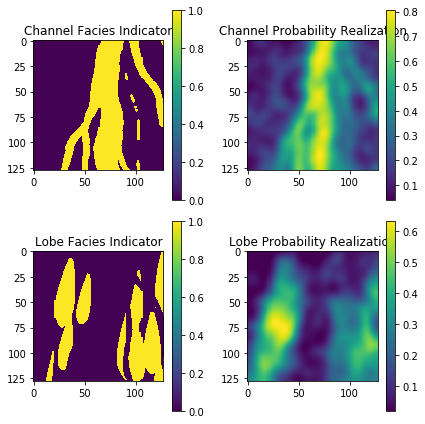

In [56]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(6, 6, forward=True)

# Top-left: Channel Facies Indicator
im0 = ax[0, 0].imshow(facies_crops_indc_ch[22, 0, :, :, 11])
ax[0, 0].set_title('Channel Facies Indicator')
fig.colorbar(im0, ax=ax[0, 0])

# Top-right: Channel Probability Realization
im1 = ax[0, 1].imshow(prob_rlzs[22, 0, :, :, 11].astype(np.float32))
ax[0, 1].set_title('Channel Probability Realization')
fig.colorbar(im1, ax=ax[0, 1])

# Bottom-left: Lobe Facies Indicator
im2 = ax[1, 0].imshow(facies_crops_indc_lobe[22, 0, :, :, 30])
ax[1, 0].set_title('Lobe Facies Indicator')
fig.colorbar(im2, ax=ax[1, 0])

# Bottom-right: Lobe Probability Realization
im3 = ax[1, 1].imshow(prob_rlzs[22, 1, :, :, 30].astype(np.float32))
ax[1, 1].set_title('Lobe Probability Realization')
fig.colorbar(im3, ax=ax[1, 1])

plt.tight_layout()
plt.show()


### 6. Downsample and save training datasets

##### Save directory

In [65]:

tfrecord_dir_training = '/scratch/users/suihong/GANSimData/TrainingData'

##### Downsample and save

In [66]:
import tensorflow.compat.v1 as tf
from scipy import stats
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_cubes, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_cubes    = expected_cubes
        self.cur_cubes         = 0
        self.shape              = None
        self.max_res_log2      = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert(os.path.isdir(self.tfrecord_dir))
        
    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d cubes.' % self.cur_cubes)

    def choose_shuffled_order(self): # Note: Cubes and labels must be added in shuffled order.
        order = np.arange(self.expected_cubes)
        np.random.RandomState(123).shuffle(order)
        return order
         
    def add_real_cube(self, real_cube):
        def downscale_factor(cube):
            cube_dim = cube.shape[1:]
            cube_dim_log2 = np.log2(cube_dim).astype(int)
            cube_dim_log2_dist = cube_dim_log2 - np.array([2, 2, 2])
            down_factor = np.where(cube_dim_log2_dist > 0, 2, 1)
            return down_factor
    
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = real_cube.shape   # [1, 64, 64, 64]
            self.max_res_log2  = max(np.log2(self.shape[1:]).astype(int))  # 6
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.max_res_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.max_res_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        assert real_cube.shape == self.shape
        
        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_cube = real_cube.astype(np.float32)
                # used to produce low-D with averaging method                
                dwscl_factor = downscale_factor(real_cube)
                fac_x, fac_y, fac_z = dwscl_factor                
                # used to produce low-D with method （once channel exist, it remain channel; otherwise, keep lobes if lobes exist）
                # facies remain order: channel (code 1), lobes (code 2), mud (code 0)
                # convert code 1 into 9 for channels, for easy frequency computation. Remember to convert back finally.
                real_cube = np.where(real_cube == 1, 9, real_cube)
                real_cube = np.expand_dims(real_cube, axis = -1)    
                # Mind where fac_z = 1
                real_cube = np.concatenate((real_cube[:, 0::fac_x, 0::fac_y, 0::fac_z], real_cube[:, 0::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, 0::fac_y, 0::fac_z], real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                                            real_cube[:, 0::fac_x, 0::fac_y, fac_z - 1::fac_z], real_cube[:, 0::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, 0::fac_y, fac_z - 1::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z]), axis = -1)
                real_cube = np.max(real_cube, axis = -1)
                real_cube = np.where(real_cube == 9, 1, real_cube)                  
            quant = np.rint(real_cube).clip(0, 2).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
            tfr_writer.write(ex.SerializeToString())
        self.cur_cubes += 1            

    def add_labels(self, labels):
        if self.print_progress:
            print('%-40s\r' % 'Saving labels...', end='', flush=True)
        #assert labels.shape[0] == self.cur_cubes
        with open(self.tfr_prefix + '-4rxx.labels', 'wb') as f:
            np.save(f, labels.astype(np.float32))

    def add_prob_cube(self, prob_cube):
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = prob_cube.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add probcubes writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-2probcubes.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting prob_cube into tfrecord file
        quant = prob_cube.clip(0, 1).astype(np.float16)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_cubes += 1   
        
    def add_well_facies(self, well_facies):
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = well_facies.shape
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            # add well_facies writer into self.tfr_writers    
            tfr_file = self.tfr_prefix + '-3wellfacies.tfrecords' 
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        # Writting well_facies into tfrecord file
        quant = well_facies.astype(np.uint8)
        ex = tf.train.Example(features=tf.train.Features(feature={
            'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
            'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
        self.tfr_writers[0].write(ex.SerializeToString())
        self.cur_cubes += 1   
        
    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.close()

In [67]:
# We don't consider lables in this case, thus generate one

labels = np.zeros((facies_crops.shape[0], 1)) 

In [68]:
with TFRecordExporter(tfrecord_dir_training, facies_crops.shape[0]) as tfr:
    order = tfr.choose_shuffled_order()
    for idx in range(order.size):
        tfr.add_real_cube(facies_crops[order[idx]]) 
    tfr.add_labels(labels[order])   

Creating dataset "/scratch/users/suihong/GANSimData/TrainingData"
Added 76 cubes.                         


In [69]:
with TFRecordExporter(tfrecord_dir_training, well_facies.shape[0]) as tfr:
    for idx in range(well_facies.shape[0]):
        tfr.add_well_facies(well_facies[idx])      

Creating dataset "/scratch/users/suihong/GANSimData/TrainingData"
Added 76 cubes.                         


In [70]:
with TFRecordExporter(tfrecord_dir_training, prob_rlzs.shape[0]) as tfr:
    for idx in range(prob_rlzs.shape[0]):
        tfr.add_prob_cube(prob_rlzs[idx])      

Creating dataset "/scratch/users/suihong/GANSimData/TrainingData"
Added 76 cubes.                         
